# CNN Cancer Detection Kaggle Mini Project

The goal of this mini project is to detect metastatic cancer which is a cancer that has spread from another part of the body and has the same type of cancer cells. The Kaggle competition data consists of a set of training image files in a train directory, a set of test image files in a test directory, and a train_labels.csv file indicating which train files are positive for cancer and which ones are negative. The images are color 96x96 pixel.The Kaggle competition data was taken from the Grand Challenge PatchCamelyon ( https://github.com/basveeling/pcam) which has a even 50/50 split between positive and negative, however, it was modified slightly, i.e. duplicates were removed. The project will first start with exploratory analysis, create and train a TensorFlow Model against the training data, create a Kaggle competition submission file, and finall submit the file to see how our Kaggle evaluates our model.




## Exploratory Data Analysis

The data is found in the ./data directory which contains the train_labels.csv file, a train directory holding the training image files, and a test directory which will use to test our model and create a Kaggle submission.csv file. There are training 220025 images. This is shown by counting how many rows are in the train_labels.csv file which matches the number of files in the train directory. 59% (or 130908) of the images are cancer free and 41% (or 89117) of the images show cancer. The original data set had a 50/50 split between positive and negative classes, however, since the kaggle version of the data set removed duplicates this ratio was not maintained. This does not represent a large class imbalance and this distribution should work fine for training purposes. A small sample of positive and negative images are displayed but visual inspection does not easily how what indicates the presence of cancer (good thing we are using machine learning!).


In [2]:
import numpy as np
import pandas as pd
import os

train_labels = pd.read_csv('./data/kaggle/train_labels.csv', dtype=str)
print(os.listdir('./data/kaggle'))
print("Size of training data set is",len(train_labels))
print("Number of files in the train directory", len(os.listdir('./data/kaggle/train')))
print("Number of files in the test directory", len(os.listdir('./data/kaggle/test')))

['train_labels.csv', 'sample_submission.csv', 'test', 'train']
Size of training data set is 220025
Number of files in the train directory 220025
Number of files in the test directory 57458


The train_label.csv file has a field called label where the 1 value indicates the presence of cancer and the value of 0 indicates no cancer is present. The distribution of positive and negative are shown in the following diagrams.

In [98]:
train_labels.describe()

,id,label
count,220025,220025
unique,220025,2
top,f38a6374c348f90b587e046aac6079959adf3835,0
freq,1,130908


In [99]:
train_labels.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [100]:
label_counts = train_labels['label'].value_counts()
print(label_counts)
print(label_counts[0])

0    130908
1     89117
Name: label, dtype: int64
130908


<Axes: title={'center': 'Cancer Image Class Frequency'}, xlabel='Class', ylabel='Frequency'>

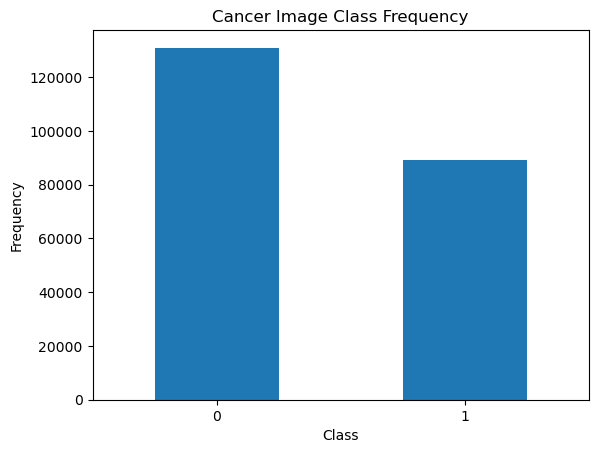

In [101]:
label_counts.plot.bar(rot=0, title = "Cancer Image Class Frequency", xlabel = "Class", ylabel = "Frequency")

<Axes: title={'center': 'Class percetage'}, ylabel='label'>

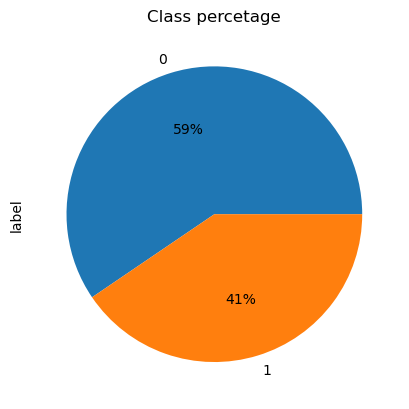

In [102]:

label_counts.plot.pie(title='Class percetage', autopct='%1.0f%%')

### The following shows three cancer negative images

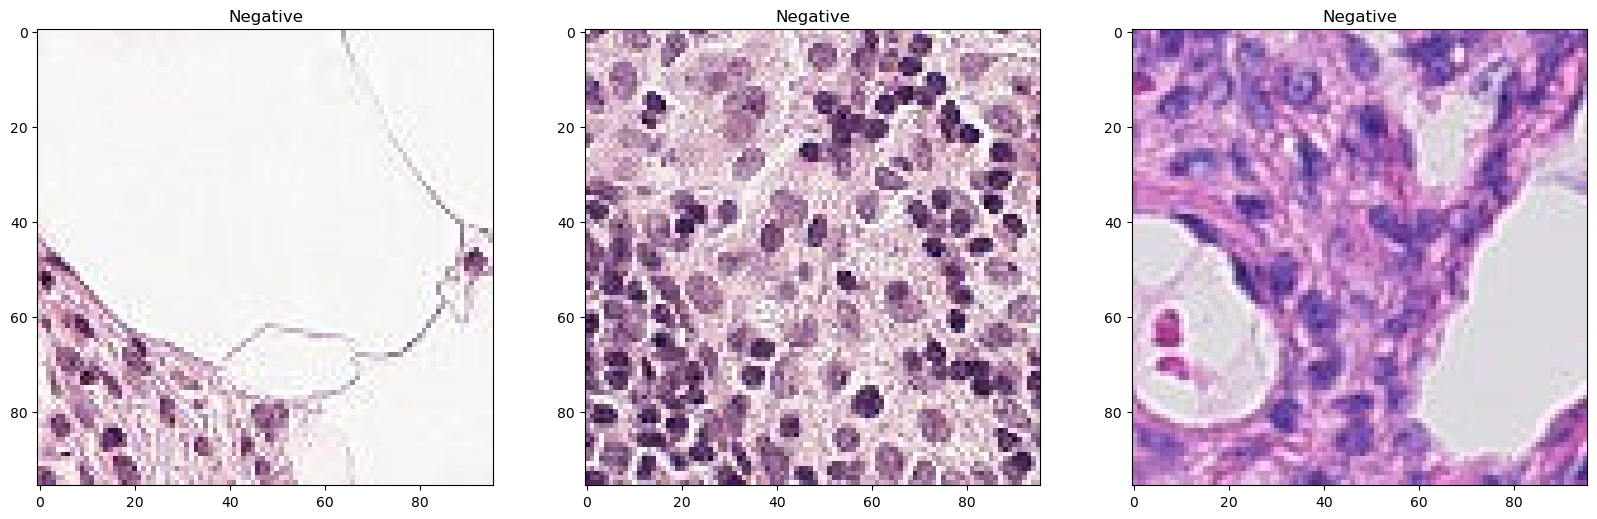

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

neg = train_labels[train_labels['label'] == '0']

fig, ax = plt.subplots(1, 3,figsize=(20,20))

for i in range(0, 3):
    ax = plt.subplot(1, 3, i+1)
    filename = neg['id'].iloc[i]
    img = mpimg.imread(f'./data/kaggle/train/{filename}.tif')
    ax.imshow(img)
    ax.set_title('Negative')

### The following shows three cancer positive images

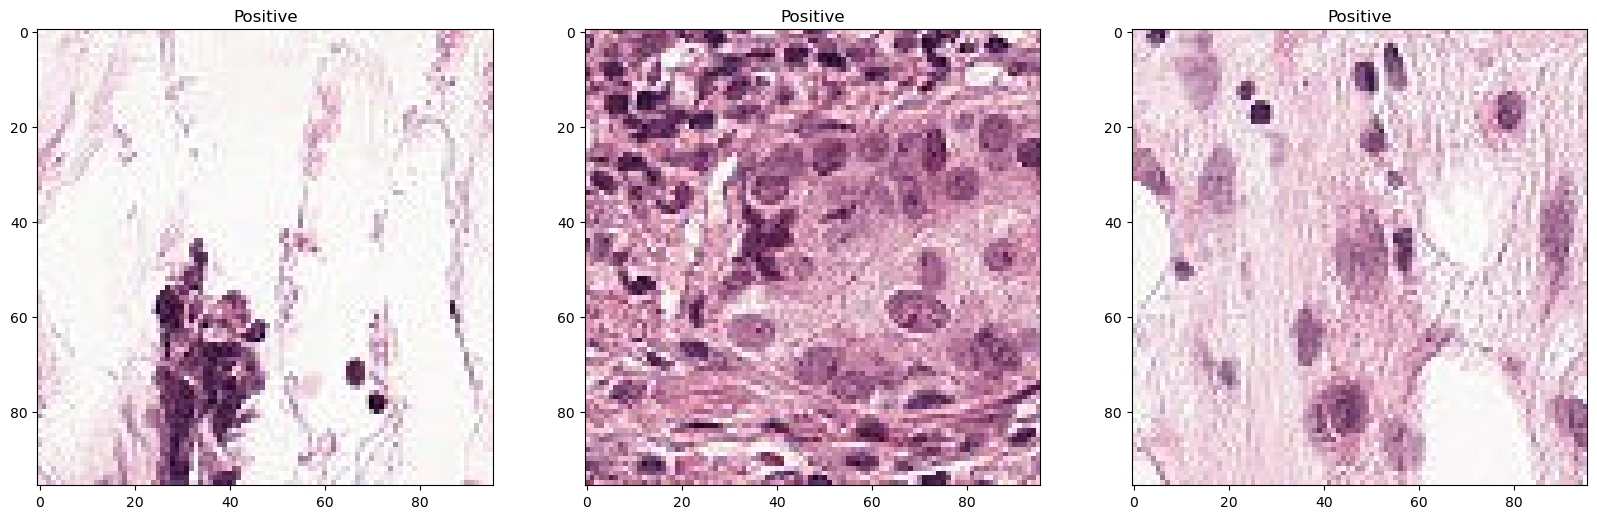

In [9]:
pos = train_labels[train_labels['label'] == '1']
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

for i in range(0, 3):
    ax = plt.subplot(1, 3, i + 1)
    filename = pos['id'].iloc[i]
    img = mpimg.imread(f'./data/kaggle/train/{filename}.tif')
    ax.imshow(img)
    ax.set_title('Positive')
#

## Classification using TensorFlow Deep Learning


The the following architecture is used:
- ReLU activation function for the hidden layers
- Sigmoid activation function for the output layer
- 3x3 filters
- [Conv-Conv-MaxPool]n structure where n = 2

Both https://analyticsindiamag.com/everything-you-should-know-about-dropouts-and-batchnormalization-in-cnn/ and https://github.com/PacktPublishing/Deep-Learning-with-TensorFlow-and-Keras-3rd-edition/tree/main were examined to help develop the basic code structure and create the dense layers.




In [10]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(train_labels, test_size=0.2, random_state=1234, stratify=train_labels.label)
# add the .tif extension so that the file name is properly referenced
train_data['id'] = train_data['id'] + '.tif'
valid_data['id'] = valid_data['id'] + '.tif'

In [11]:
#import tensorflow and keras as well as any necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [103]:
#create the training and validation subsets
# not that we are using a deprecated APU because the most recent TensorFlow recommended approach does not support .tif files!
train_datagen=ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_dataframe(dataframe=train_data,directory="./data/kaggle/train/",
                                                  x_col="id",y_col="label",batch_size=32,seed=1234,shuffle=True,
                                                  class_mode="binary",target_size=(96,96))

valid_generator=train_datagen.flow_from_dataframe(dataframe=valid_data,directory="./data/kaggle/train/",
                                                  x_col="id",y_col="label",batch_size=32,seed=1234,shuffle=True,
                                                  class_mode="binary",target_size=(96,96))


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [88]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
IMG_CHANNELS = 3
IMG_ROWS = 96
IMG_COLS = 96
#constant
BATCH_SIZE = 128
EPOCHS = 5
CLASSES = 1
VERBOSE = 1
VALIDATION_SPLIT = 0.2
INPUT_SHAPE = (96,96,3)
OPTIM = tf.keras.optimizers.RMSprop(learning_rate=0.0005)

In [89]:
model = models.Sequential()
model.add(layers.Convolution2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(layers.Convolution2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Convolution2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE))
model.add(layers.Convolution2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))




In [90]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(CLASSES, activation='sigmoid'))

In [91]:
model.compile(loss='binary_crossentropy', optimizer=OPTIM, metrics=['accuracy'])


## Training and Results


5 Epochs are used for training resulting in an accuracy of 91.8% accuracy. The training accuracy by epoch is plotted and compared to the validation dataset accuracy. The validation training accurate does show that it is still increasing, so the choice of 5 epochs seems reasonable. Ideally, it would have been interesting to more epochs to see when validation accuracy start declining, however it takes a significant amount of time to run one epoch and so it was not reasonable to do this in the current time frame. With a training accuracy of 91.8%, the hope is that when it is submitted to the Kaggle for scoring, the results are above 80%.



In [92]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

#history = model.fit_generator(generator=train_generator,
#                    steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=valid_generator,
#                    validation_steps=STEP_SIZE_VALID,
#                    epochs=2, verbose=1
#)
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS, verbose=1
                    )



Epoch 1/5
5500/5500 [==============================] - 2128s 387ms/step - loss: 0.3709 - accuracy: 0.8466 - val_loss: 0.8247 - val_accuracy: 0.6971
Epoch 2/5
5500/5500 [==============================] - 2133s 388ms/step - loss: 0.2788 - accuracy: 0.8937 - val_loss: 0.8965 - val_accuracy: 0.8380
Epoch 3/5
5500/5500 [==============================] - 2199s 400ms/step - loss: 0.2497 - accuracy: 0.9076 - val_loss: 0.4139 - val_accuracy: 0.8165
Epoch 4/5
5500/5500 [==============================] - 2143s 390ms/step - loss: 0.2387 - accuracy: 0.9135 - val_loss: 1.8297 - val_accuracy: 0.7726
Epoch 5/5
5500/5500 [==============================] - 2158s 392ms/step - loss: 0.2276 - accuracy: 0.9181 - val_loss: 0.3324 - val_accuracy: 0.9009


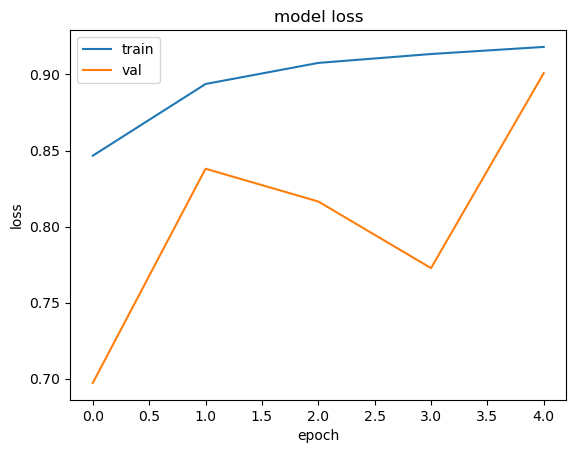

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [94]:
test_set = os.listdir('./data/kaggle/test/')

test_df = pd.DataFrame(test_set)
test_df.columns = ['id']
print(test_df.shape[0]/2)

28729.0


In [95]:
## score the test data and create a submission file
test_datagen = ImageDataGenerator(rescale=1 / 255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory="./data/kaggle/test/",
                                                  x_col="id", seed=1234, shuffle=False,
                                                  class_mode=None, target_size=(96, 96))


Found 57458 validated image filenames.


In [96]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

preds = model.predict(test_generator, verbose=1)
predictions = []


1796/1796 [==============================] - 728s 405ms/step


In [97]:
for pred in preds:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

sub = test_df.copy()
sub['id'] = sub['id'].str[:-4]
sub['label'] = predictions
sub.head()
sub.to_csv('submission.csv', index=False)


## Kaggle Submission Result

The Kaggle public score result was 88.3% and the private score was 85.9%. This shows the the trained model generalized reasonably well. Options to investigate in order to further increase model performance would be to increase the number of [Conv-Conv-MaxPool] layers with increasing  sizes, add more dense layers, and increase the number of epcohs.